This notebook is to get diffraction calibration and to correct and filter all the 4dstem tilt series diffraction patterns

In [1]:
# I had problems installing python libraries such that the python compiler was the same as here
# Installing the libraries within jupyter was a quick solution

#import sys
#sys.path.append("C:/Users/touu9536/Anaconda3/envs/4dtomo/Lib/site-packages/")
#!conda install --channel "conda-forge" --force-reinstall --yes --prefix {sys.prefix} pyxem
#!conda install --yes --prefix {sys.prefix} matplotlib
#!conda install --yes --prefix {sys.prefix} hyperspy
#!conda install --yes --prefix {sys.prefix} SimpleITK
#!conda install --yes --prefix {sys.prefix} medpy

In [2]:
#use this for interactive pop up images
#%matplotlib qt5

In [3]:
import hyperspy.api as hs
import pyxem as pxm
import numpy as np
from skimage import filters
import time
import gc
from skimage.transform import resize
from pyxem.libraries.calibration_library import CalibrationDataLibrary
from pyxem.generators.calibration_generator import CalibrationGenerator

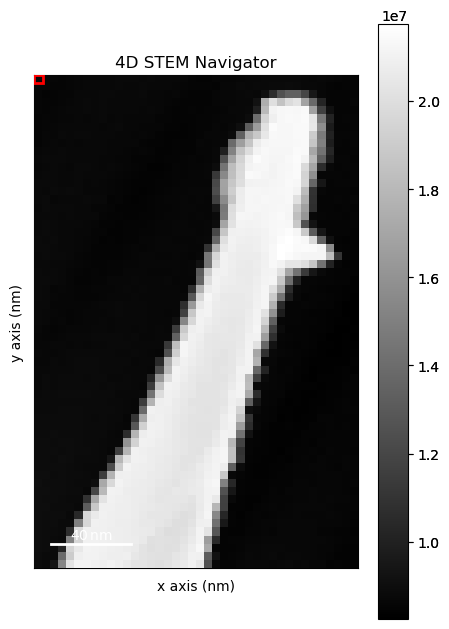

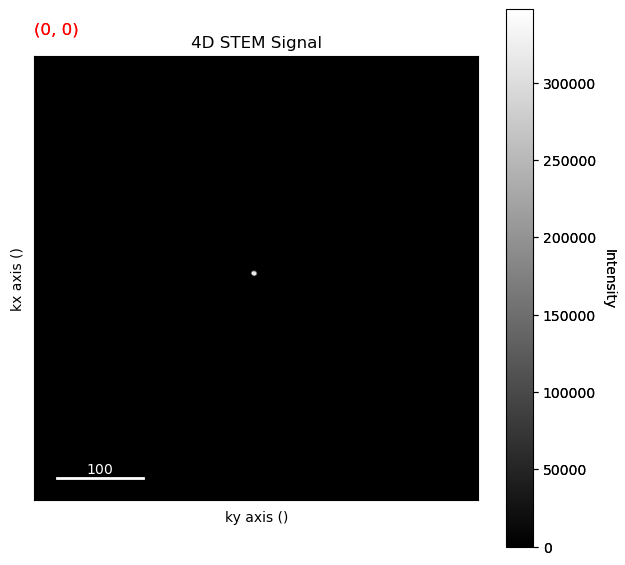

In [4]:
# test and visualize your 4dstem image
# change the path here to your .dm4 4dstem images
# image names are expected to be '4DSTEM_' + str(index)

dmpath = 'D:/data/August2022/TiNi/tomo/Tomo_23/'
test = '4DSTEM_' + str(0)

dp = hs.load(dmpath + test + '.dm4')
dp = dp.T
dp.set_signal_type('electron_diffraction')
dp.axes_manager[2].name = "ky"
dp.axes_manager[3].name = "kx"
dp.axes_manager[0].offset = 0
dp.axes_manager[1].offset = 0
dp.plot(cmap='gray',norm='auto' )

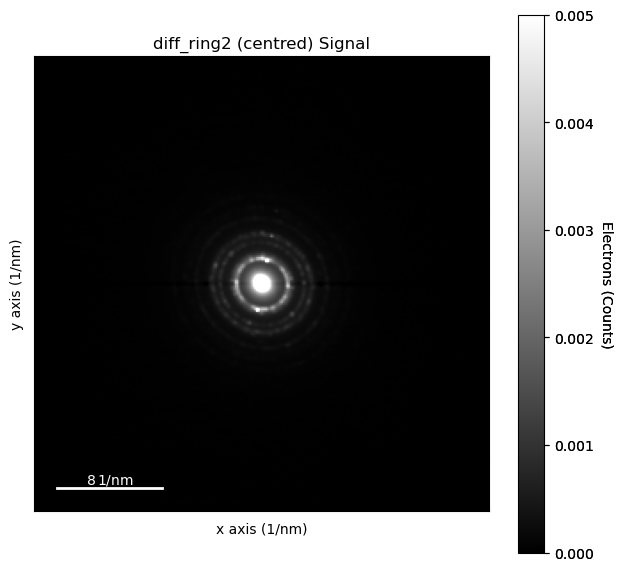

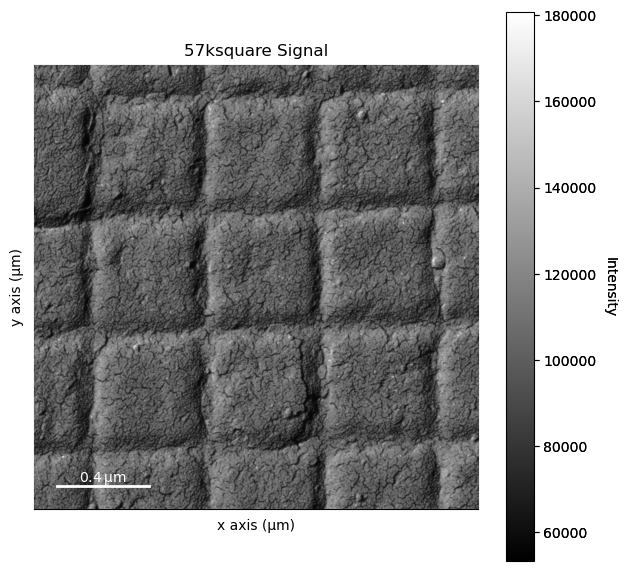

In [11]:
# change the path here to your gold diffraction ring and cross grating image

au_dpeg = hs.load('D:/data/August2022/TiNi/tomo/cali/diff_ring2 (centred).dm4')
au_im = hs.load('D:/data/August2022/TiNi/tomo/cali/57ksquare.dm4')

au_dpeg.data = au_dpeg.data.astype('float64')
au_dpeg.data *= 1 / au_dpeg.data.max()

#The final signal size will be from 512 to 256
au_dpeg.data = resize(au_dpeg.data, ( 256,256), anti_aliasing=True)

au_dpeg.plot(vmin=0,vmax=0.005,cmap='gray',norm='auto',)
au_im.plot()


In [13]:
cal = CalibrationGenerator(diffraction_pattern=au_dpeg,
                           grating_image=au_im)

In [14]:
cal.get_elliptical_distortion(mask_radius=7,
                              scale=0.0167, amplitude=0.99,
                              asymmetry=0.99,spread=4)

C:\Users\touu9536\Anaconda3\envs\4dtomo\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([[ 1.04695858, -0.02170883,  0.        ],
       [-0.02170883,  1.01003594,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


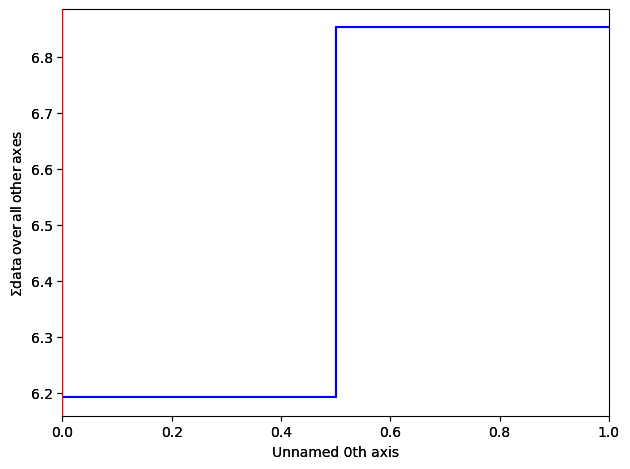

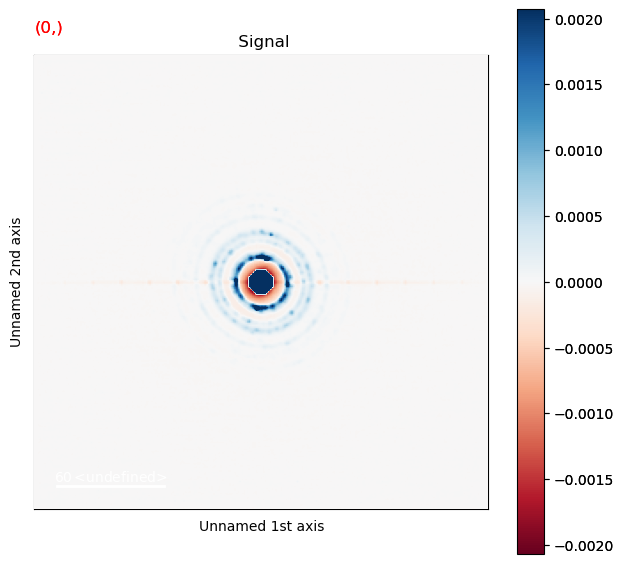

In [15]:
residuals = cal.get_distortion_residuals(mask_radius=7, spread=2)
residuals.plot(cmap='RdBu', vmax=0.001)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


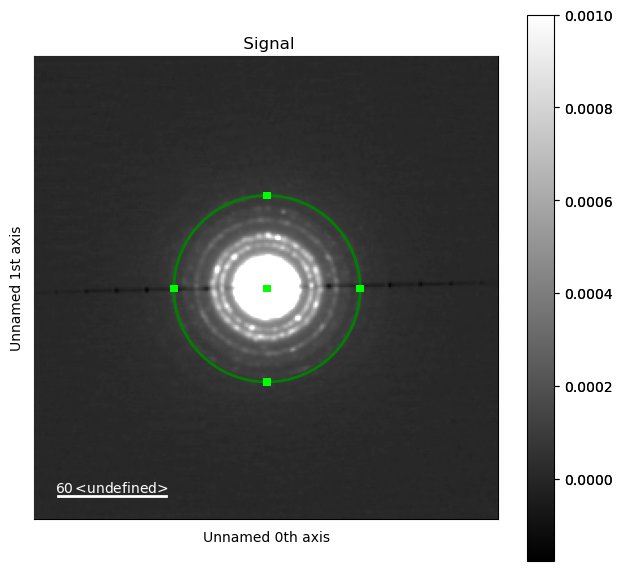

In [16]:
cal.plot_corrected_diffraction_pattern(vmax=0.001)

In [17]:
cal.affine_matrix

array([[ 1.04695858, -0.02170883,  0.        ],
       [-0.02170883,  1.01003594,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [18]:
cal.ring_params

array([-11.61264922,   0.02193679,  -0.87550121,  10.11149516,
         1.11723741,  -1.13776306])

In [19]:
diff_cal = cal.get_diffraction_calibration(mask_length=30,
                                linewidth=5)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [20]:
diff_cal

0.019013543854644616

In [48]:
cal.plot_calibrated_data(data_to_plot='au_x_grating_dp',
                         cmap='magma', vmax=0.001)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [21]:
# Set values lower than a specific value to 0 in the image
def crop_minimum(image, minimum=0.0005):
    copied = image.copy()
    copied[copied <= minimum] = 0.
    return copied

In [ ]:

# change Ntilts to your number of tilt images
# this took 3.6h with my laptop
# change the output path here

dmpath = 'D:/data/August2022/TiNi/tomo/Tomo_23/'
Ntilts = 70
outpath = 'D:/data/August2022/TiNi/tomo/Tomo_23/post/'
os.makedirs(outpath, exist_ok=True)

t = time.time()
sigma_min = 1.7
sigma_max = 13.2

for i in range(Ntilts):
    test = '4DSTEM_' + str(i)

    dp = hs.load(dmpath  + test + '.dm4')
    dp = dp.T
    dp.set_signal_type('electron_diffraction')
    dp.axes_manager[2].name = "ky"
    dp.axes_manager[3].name = "kx"
    dp.axes_manager[0].offset = 0
    dp.axes_manager[1].offset = 0

    #pixel size was acquired using DM script "findcrossgratingdistance.s"
    dp.set_scan_calibration(1.73523*8)
    dp.set_diffraction_calibration(diff_cal)

    dp= dp.subtract_diffraction_background('difference of gaussians', 
                                 min_sigma=sigma_min, 
                                 max_sigma=sigma_max)
    dp.data.compute()

    shifts = dp.center_direct_beam(method='cross_correlate',
                                      half_square_width=15,
                                      return_shifts=True,
                                      radius_start=2,
                                      radius_finish=6)

    shifts.compute()

    dp.apply_affine_transformation(cal.get_correction_matrix(),
                                   keep_dtype=True)

    # smooth out the output
    dp = dp.map(filters.gaussian, sigma=0.5, inplace=False)
    # remove low intensities
    dp = dp.map(crop_minimum, minimum = 0.0005, inplace=False)

    dp.save(outpath + test + '.hdf5', overwrite=True)

    del dp
    gc.collect()
    
elapsed = time.time() - t
elapsed
